
# Triage Efficiency

(how long it takes to triage the scene) What record in the FRVRS log is there that shows that the scene triage is complete?


## 0. Importing libraries and still patients data frame

In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from notebook_utils import NotebookUtilities
from pandas import DataFrame
import humanize
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get the time that all still patients are engaged
if nu.pickle_exists('still_patients_df'):
    still_patients_df = nu.load_object('still_patients_df')
    print(still_patients_df.shape)
    df = still_patients_df.sample(4).dropna(axis='columns', how='all')
    display(df.T)

(2968, 9)


,2287,270,2380,1138
logger_version,1.0,1.3,1.0,1.0
session_uuid,cdc7b0ec-a883-4705-9b55-b618d429808e,14678e1f-aa1c-4a67-a31f-65dd3e2238ca,d347b967-5e20-4527-95dd-3a0fdf73af1d,60d42fe6-f30b-4eab-ba01-644dde714e4d
time_group,2,0,2,2
patient_id,Bob_0 Root,Mike_6 Root,Gary_1 Root,Bob_0 Root
first_notice,223819,23792,374162,357743
first_action,231006.0,NaN,380952.0,368365.0
first_engagement,438422.0,NaN,405623.0,404448.0
notice_to_engagement,214603.0,NaN,31461.0,46705.0
action_to_engagement,207416.0,NaN,24671.0,36083.0



<img src="http://localhost:8888/files/itm-analysis-reporting/saves/png/fs_pcp_time_to_triage_completion.png" />

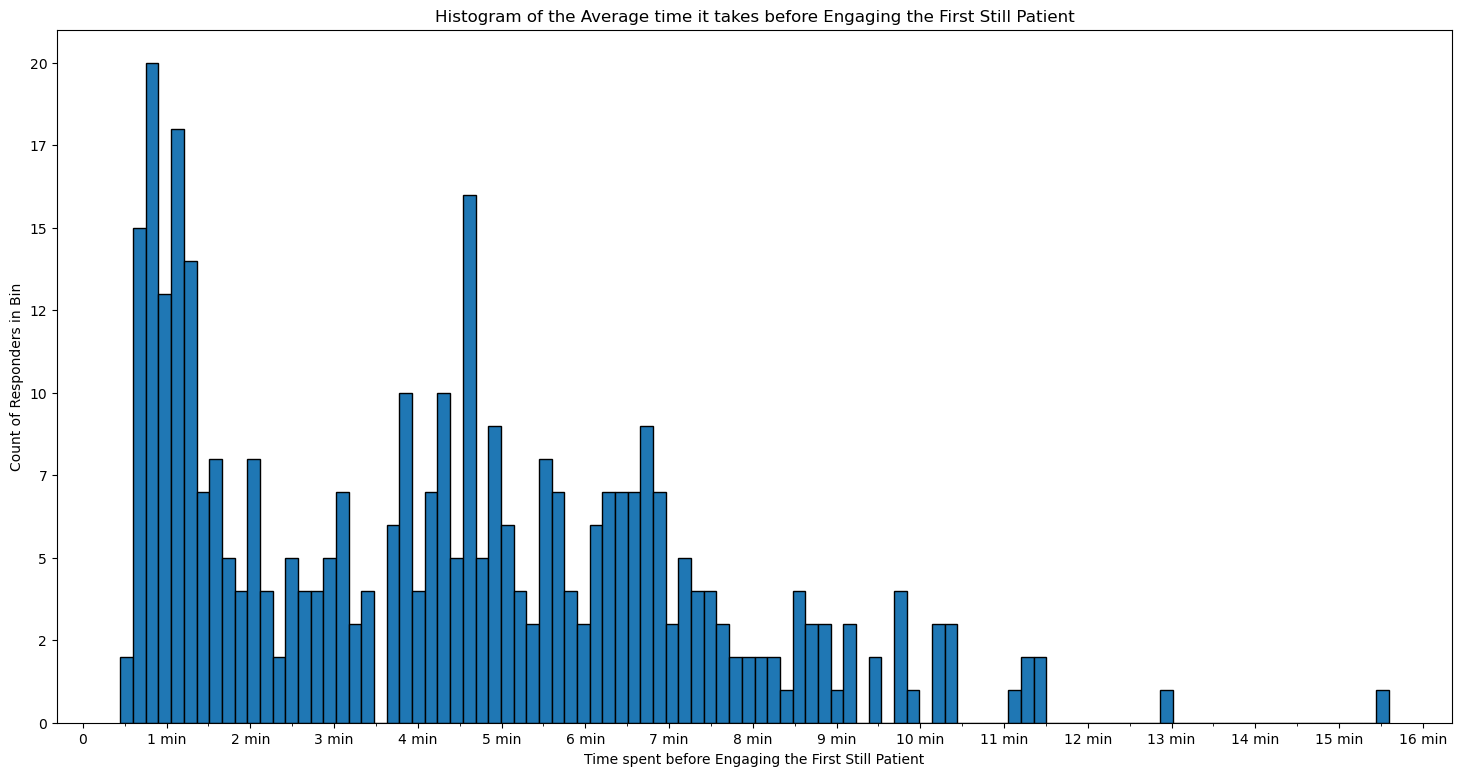

In [5]:

# Get the time to engage the first stills
groupby_columns = ['session_uuid', 'time_group']
min_first_engagement_df = still_patients_df.groupby(groupby_columns).filter(
    lambda df: not df.first_engagement.isnull().any()
).groupby(groupby_columns).min().reset_index(drop=False).sort_values('first_engagement')
min_first_engagement_df = min_first_engagement_df.rename(
    columns={k: 'min_' + k for k in min_first_engagement_df.columns if k not in groupby_columns}
)

# Filter out anything after 16 minutes per Nicholas Kman
sixteen_minutes = 1_000 * 60 * 16
mask_series = (min_first_engagement_df.min_first_engagement < sixteen_minutes)
df = min_first_engagement_df[mask_series]

# Make it so that the x-axis tick labels appear like 0, 30, 1 min, 1:30, 2 min, etc
get_xtick_text = lambda text_obj: nu.format_timedelta(
    timedelta(milliseconds=int(text_obj.get_position()[0]))
)

# Histogram of the time that it takes to triage the scene (assuming a still patient is the first engaged)
xlabel = 'Time spent before Engaging the First Still Patient'
title = 'Histogram of the Average time it takes before Engaging the First Still Patient'
ylabel = 'Count of Responders in Bin'
ax = nu.plot_histogram(df, 'min_first_engagement', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title, ylabel=ylabel, xticks_are_temporal=True)

In [6]:

# Can you provide the following statistics for this distribution: mean, median, mode, SD, Interquartile range?
columns_list = [
    'min_first_engagement'
]

# Filter out anything after 16 minutes per Nicholas Kman
sixteen_minutes = 1_000 * 60 * 16
mask_series = (min_first_engagement_df.min_first_engagement < sixteen_minutes)
df = min_first_engagement_df[mask_series][columns_list]
nu.show_time_statistics(columns_list, df)

,mean,mode,median,SD,min,25%,50%,75%,max
min_first_engagement,4:20,27,4:16,±2:50,27,1:33,4:16,6:21,15:35
